# 1-D and 2-D Convolutional Neural Networks in Pytorch
This was a 1D and 2D CNN project I completed in 2022. I've set up this notebook to read like an experiment, and walk the viewer through the creation of a variety of CNN's and their application on a ECG dataset. 

## Overview

I experimented with convolutional neural network for 2-dimensional input samples (images), in class `CNN2D`, by applying it to the MNIST (hand drawn image set) data.  I also  defined a new class for handling 1-dimensional input samples, called `CNN1D`, that extends `CNN2D`. Near the end of this notebook I tested my NN on a ECG dataset.

## High-level Project Explaination

In this project, I started by developing a 2D Convolutional Neural Network (CNN). A 2D CNN is a type of deep learning model used for image classification and processing tasks. In a 2D CNN, the input image is processed through multiple layers of filters that convolve with the input to extract features. The extracted features are then processed through non-linear activation functions and subsampled by pooling. The final output is a predicted class label. 2D CNNs are widely used in computer vision tasks due to their ability to learn rich representations from training data.

I loaded a dataset of over 10,000 hand-drawn digits and applied my 2D CNN to the dataset.

Next, I implemented a 1D CNN. 1D CNNs are used for processing sequences of data, such as time series data, audio signals, or text. The input in a 1D CNN is a 1D array or sequence of values, and the filters in the convolutional layers are designed to detect specific patterns and structures in the input sequence. In contrast, 2D CNNs are designed to process images. The input in a 2D CNN is a 2D array of pixels, and the filters in the convolutional layers are designed to detect specific patterns and textures in the image.

Another difference between the two is the way the convolutional layers are implemented. In a 1D CNN, the convolutions are performed along the temporal axis, while in a 2D CNN, the convolutions are performed on both the vertical and horizontal axes. Additionally, the subsampling or pooling operation in a 1D CNN typically reduces the temporal dimension, while in a 2D CNN, it reduces the spatial dimensions.

To conclude the project, I loaded an electrocardiogram (ECG) dataset and used the 1D CNN with the best architecture to classify each 2,000-sample segment into the classes "normal" or "arrythmia."

In [24]:
import numpy as np
import torch
import pandas

import matplotlib.pyplot as plt

## `CNN2D` class

In [25]:
import numpy as np
import torch


class CNN2D(torch.nn.Module):

    def __init__(self, n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                 patch_size_per_conv_layer, stride_per_conv_layer, activation_function='tanh', device='cpu'):

        super().__init__()

        self.device = device

        n_conv_layers = len(n_hiddens_per_conv_layer)
        if (len(patch_size_per_conv_layer) != n_conv_layers
            or len(stride_per_conv_layer) != n_conv_layers):
            raise Exception('The lengths of n_hiddens_per_conv_layer, patch_size_per_conv_layer, and stride_per_conv_layer must be equal.')

        self.activation_function = torch.tanh if activation_function == 'tanh' else torch.relu

        self.make_conv_and_fc_layers(n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                                     patch_size_per_conv_layer, stride_per_conv_layer)
        
        self.Xmeans = None
        self.to(self.device)

    def make_conv_and_fc_layers(self, n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                                patch_size_per_conv_layer, stride_per_conv_layer):
        # Create all convolutional layers
        # First argument to first Conv2d is number of channels for each pixel.
        # Just 1 for our grayscale images.
        n_in = 1
        input_hw = int(np.sqrt(n_inputs))  # original input image height (=width because image assumed square)
        self.conv_layers = torch.nn.ModuleList()
        layeri = 0
        for nh, patch_size, stride in zip(n_hiddens_per_conv_layer,
                                          patch_size_per_conv_layer,
                                          stride_per_conv_layer):
            self.conv_layers.append(torch.nn.Conv2d(n_in, nh, kernel_size=patch_size, stride=stride))
            conv_layer_output_hw = (input_hw - patch_size) // stride + 1
            if conv_layer_output_hw <= 0:
                raise Exception(f'''For conv layer {layeri}, input_hw of {input_hw} is less than patch_size {patch_size}.
Try reducing the patch_size for this layer or for the previous layer.''')
            input_hw = conv_layer_output_hw  # for next trip through this loop
            n_in = nh
            layeri += 1
           
        # Create all fully connected layers.  First must determine number of inputs to first
        # fully-connected layer that results from flattening the images coming out of the last
        # convolutional layer.
        n_in = input_hw ** 2 * n_in
        self.fc_layers = torch.nn.ModuleList()
        for nh in n_hiddens_per_fc_layer:
            self.fc_layers.append(torch.nn.Linear(n_in, nh))
            n_in = nh
        self.fc_layers.append(torch.nn.Linear(n_in, n_outputs))

    def forward_all_outputs(self, X):
        n_samples = X.shape[0]
        Ys = [X]
        for conv_layer in self.conv_layers:
            Ys.append(self.activation_function(conv_layer(Ys[-1])))

        flattened_input = Ys[-1].reshape(n_samples, -1)

        for layeri, fc_layer in enumerate(self.fc_layers[:-1]):
            if layeri == 0:
                Ys.append(self.activation_function(fc_layer(flattened_input)))
            else:
                Ys.append(self.activation_function(fc_layer(Ys[-1])))

        if len(self.fc_layers) == 1:
            # only the output layer
            Ys.append(self.fc_layers[-1](flattened_input))
        else:
            Ys.append(self.fc_layers[-1](Ys[-1]))

        return Ys

    def forward(self, X):
        Ys = self.forward_all_outputs(X)
        return Ys[-1]

    def train(self, X, T, batch_size, n_epochs, learning_rate, method='sgd', verbose=True):
        '''X and T must be numpy arrays'''

        self.classes = np.unique(T)
        T = np.arange(len(self.classes))[np.where(T.reshape(-1, 1) == self.classes)[1]]

        # Set data matrices to torch.tensors
        X = torch.from_numpy(X).float().to(self.device)
        T = torch.from_numpy(T).long().to(self.device)  # required for classification in pytorch

        # Setup standardization parameters
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xstds[self.Xstds == 0] = 1  # So we don't divide by zero when standardizing

        # Standardize X
        X = (X - self.Xmeans) / self.Xstds

        X.requires_grad_(True)

        if method == 'sgd':
            optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate, momentum=0.9)
        else:
            optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

        CELoss = torch.nn.CrossEntropyLoss(reduction='mean')
        self.error_trace = []

        for epoch in range(n_epochs):

            num_batches = X.shape[0] // batch_size
            loss_sum = 0

            for k in range(num_batches):
                start = k * batch_size
                end = (k + 1) * batch_size
                X_batch = X[start:end, ...]
                T_batch = T[start:end, ...]

                Y = self.forward(X_batch)

                loss = CELoss(Y, T_batch)
                loss.backward()

                # Update parameters
                optimizer.step()
                optimizer.zero_grad()

                loss_sum += loss

            self.error_trace.append(loss_sum / num_batches)

            if verbose and (epoch + 1) % (max(1, n_epochs // 10)) == 0:
                print(f'{method}: Epoch {epoch + 1} Loss {self.error_trace[-1]:.3f}')

        return self

    def softmax(self, Y):
        '''Apply to final layer weighted sum outputs'''
        # Trick to avoid overflow
        maxY = torch.max(Y, axis=1)[0].reshape((-1, 1))
        expY = torch.exp(Y - maxY)
        denom = torch.sum(expY, axis=1).reshape((-1, 1))
        Y = expY / denom
        return Y

    def use(self, X):
        # Set input matrix to torch.tensors
        X = torch.from_numpy(X).float().to(self.device)
        # Standardize X
        X = (X - self.Xmeans) / self.Xstds
        # Calculate output of net for all samples in X
        Y = self.forward(X)
        # Convert output to class probabilities
        probs = self.softmax(Y)
        # For each sample pick highest probability and translate that to class labels
        classes = self.classes[torch.argmax(probs, axis=1).cpu().numpy()].reshape(-1, 1)
        return classes, probs.detach().cpu().numpy()

### CNN2D on MNIST Digits

I used a bunch (50,000) images of hand drawn digits from [this deeplearning.net site](http://deeplearning.net/tutorial/gettingstarted.html).  To use, download `mnist.pkl.gz` 

This pickle file includes data already partitioned into training, validation, and test sets.  To read it into python, I used the following steps...

In [26]:
import pickle
import gzip

with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

Xtrain = train_set[0]
Ttrain = train_set[1].reshape(-1, 1)

Xval = valid_set[0]
Tval = valid_set[1].reshape(-1, 1)

Xtest = test_set[0]
Ttest = test_set[1].reshape(-1, 1)

Xtrain = Xtrain.reshape(-1, 1, 28, 28)
Xtest = Xtest.reshape(-1, 1, 28, 28)

print(Xtrain.shape, Ttrain.shape,  Xval.shape, Tval.shape,  Xtest.shape, Ttest.shape)

(50000, 1, 28, 28) (50000, 1) (10000, 784) (10000, 1) (10000, 1, 28, 28) (10000, 1)


In [27]:
device = 'cpu'
if torch.cuda.is_available():
    y_or_n = input('Would you like to run on the GPU? (y or n): ')
    if y_or_n == 'y' or y_or_n == 'yes':
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on', device)

Running on cpu


In [28]:
len(np.unique(Ttrain))

10

In [30]:
n_hiddens_per_conv_layer = [10, 10]
patch_size_per_conv_layer = [10, 5]
stride_per_conv_layer=[4, 2]
n_hiddens_per_fc_layer = [5]

cnnet = CNN2D(28 * 28, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, len(np.unique(Ttrain)), 
              patch_size_per_conv_layer, stride_per_conv_layer, device=device)

n_epochs = 20
batch_size = 500
learning_rate = 0.01

cnnet.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')

adam: Epoch 2 Loss 0.396
adam: Epoch 4 Loss 0.246
adam: Epoch 6 Loss 0.208
adam: Epoch 8 Loss 0.178
adam: Epoch 10 Loss 0.169
adam: Epoch 12 Loss 0.160
adam: Epoch 14 Loss 0.158
adam: Epoch 16 Loss 0.150
adam: Epoch 18 Loss 0.146
adam: Epoch 20 Loss 0.147


CNN2D(
  (conv_layers): ModuleList(
    (0): Conv2d(1, 10, kernel_size=(10, 10), stride=(4, 4))
    (1): Conv2d(10, 10, kernel_size=(5, 5), stride=(2, 2))
  )
  (fc_layers): ModuleList(
    (0): Linear(in_features=10, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=10, bias=True)
  )
)

In [31]:
def confusion_matrix(Y_classes, T):
    class_names = np.unique(T)
    table = []
    for true_class in class_names:
        row = []
        for Y_class in class_names:
            row.append(100 * np.mean(Y_classes[T == true_class] == Y_class))
        table.append(row)
    conf_matrix = pandas.DataFrame(table, index=class_names, columns=class_names)
    return conf_matrix

In [32]:
Classes, _ = cnnet.use(Xtest)
perc_correct = 100 * np.mean(Classes == Ttest)
print(f'Test accuracy in percent correct: {perc_correct:.2f}')
confusion_matrix(Classes, Ttest)

Test accuracy in percent correct: 94.61


,0,1,2,3,4,5,6,7,8,9
0,97.653061,0.000000,0.000000,0.000000,0.000000,0.204082,0.918367,0.204082,0.612245,0.408163
1,0.000000,98.237885,0.440529,0.088106,0.088106,0.000000,0.264317,0.176211,0.616740,0.088106
2,0.581395,0.775194,94.186047,2.519380,0.000000,0.000000,0.387597,0.581395,0.968992,0.000000
3,0.297030,0.000000,1.287129,93.960396,0.198020,1.188119,0.000000,1.683168,0.990099,0.396040
4,0.101833,0.407332,0.203666,0.000000,95.112016,0.101833,1.323829,0.203666,0.203666,2.342159
5,0.672646,0.000000,0.336323,1.008969,0.112108,92.040359,1.233184,0.224215,2.242152,2.130045
6,1.148225,0.835073,0.626305,0.000000,0.417537,0.939457,95.407098,0.000000,0.626305,0.000000
7,0.778210,0.875486,1.750973,0.875486,1.070039,0.000000,0.000000,92.801556,0.097276,1.750973
8,2.156057,0.410678,0.821355,1.437372,0.718686,0.616016,0.102669,0.205339,92.915811,0.616016
9,0.396432,0.495540,0.000000,0.792864,2.378593,0.594648,0.198216,0.891972,1.090188,93.161546


### Experiments to Explore CNN Architecture

1. Compare test accuracy of CNN2D nets with one, two and three convolutional layers, each with 10 units and patch sizes of 5 and strides of 1.


In [34]:
CNN2D_results_convolutional = []

In [35]:
def accuracy_of_cnn2d_convolutional(ith_conv_layers):
    
    n_epochs = 20
    batch_size = 500
    learning_rate = 0.01
    n_hiddens_per_fc_layer = [5]

    print("CNN2D Net with ", ith_conv_layers, " -----------------------")
    
    n_hiddens_per_conv = list(map(int, (10 * np.ones(ith_conv_layers))))
    patch_size_per_conv = list(map(int, (5 * np.ones(ith_conv_layers))))
    stride_per_conv = list(map(int, (1 * np.ones(ith_conv_layers))))
    
    print(n_hiddens_per_conv)
    
    my_CNNNET = CNN2D(28 * 28, n_hiddens_per_conv, n_hiddens_per_fc_layer, len(np.unique(Ttrain)), patch_size_per_conv, stride_per_conv, device=device)
        
    my_CNNNET.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method = 'adam')
        
    class_train, _ = my_CNNNET.use(Xtrain)
    percentage_correct_train = 100 * np.mean(class_train == Ttrain)
    
    class_test, _ = my_CNNNET.use(Xtest)
    percentange_correct_test = 100 * np.mean(class_test == Ttest)
    
    CNN2D_results_convolutional.append([n_hiddens_per_conv, percentage_correct_train, percentange_correct_test])

In [36]:
accuracy_of_cnn2d_convolutional(1)

CNN2D Net with  1  -----------------------
[10]
adam: Epoch 2 Loss 0.785
adam: Epoch 4 Loss 0.655
adam: Epoch 6 Loss 0.582
adam: Epoch 8 Loss 0.557
adam: Epoch 10 Loss 0.512
adam: Epoch 12 Loss 0.486
adam: Epoch 14 Loss 0.449
adam: Epoch 16 Loss 0.434
adam: Epoch 18 Loss 0.418
adam: Epoch 20 Loss 0.418


In [37]:
accuracy_of_cnn2d_convolutional(2)

CNN2D Net with  2  -----------------------
[10, 10]
adam: Epoch 2 Loss 0.583
adam: Epoch 4 Loss 0.405
adam: Epoch 6 Loss 0.368
adam: Epoch 8 Loss 0.336
adam: Epoch 10 Loss 0.311
adam: Epoch 12 Loss 0.298
adam: Epoch 14 Loss 0.277
adam: Epoch 16 Loss 0.317
adam: Epoch 18 Loss 0.282
adam: Epoch 20 Loss 0.262


In [38]:
accuracy_of_cnn2d_convolutional(3)

CNN2D Net with  3  -----------------------
[10, 10, 10]
adam: Epoch 2 Loss 0.556
adam: Epoch 4 Loss 0.437
adam: Epoch 6 Loss 0.346
adam: Epoch 8 Loss 0.333
adam: Epoch 10 Loss 0.321
adam: Epoch 12 Loss 0.297
adam: Epoch 14 Loss 0.309
adam: Epoch 16 Loss 0.267
adam: Epoch 18 Loss 0.262
adam: Epoch 20 Loss 0.267


In [39]:
pandas.DataFrame(CNN2D_results_convolutional, columns = ('Hidden Conv Layers', 'Train Accuracy', 'Test Accuracy'))

,Hidden Conv Layers,Train Accuracy,Test Accuracy
0,[10],91.338,90.80
1,"[10, 10]",93.298,93.65
2,"[10, 10, 10]",92.796,93.44



As seen in the table above, hidden conv layers of 2 performed best at identifying images correctly in the dataset.

2. Using the best number of convolutional layers found in Step 1, compare the test accuracies of CNN2d nets with zero, one, and two fully-connected layers each with 10 hidden units.

In [57]:
CNN2D_results_full = []

In [58]:
def accuracy_of_cnn2d_full(ith_full_layers):
    
    n_epochs = 20
    batch_size = 500
    learning_rate = 0.01
    n_hiddens_per_conv = [10, 10]
    patch_per_conv = [5, 5]
    stride_per_conv = [1, 1]

    print("CNN2D Net with ", ith_full_layers, " -----------------------")
    
    n_hiddens_per_fc = list(map(int, (10 * np.ones(ith_full_layers))))
    
    print(n_hiddens_per_fc)
    
    my_CNNNET = CNN2D(28 * 28, n_hiddens_per_conv, n_hiddens_per_fc_layer, len(np.unique(Ttrain)), patch_per_conv, stride_per_conv, device=device)
        
    my_CNNNET.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method = 'adam')
        
    class_train, _ = my_CNNNET.use(Xtrain)
    percentage_correct_train = 100 * np.mean(class_train == Ttrain)
    
    class_test, _ = my_CNNNET.use(Xtest)
    percentange_correct_test = 100 * np.mean(class_test == Ttest)
    
    CNN2D_results_full.append([n_hiddens_per_fc, percentage_correct_train, percentange_correct_test])

In [59]:
accuracy_of_cnn2d_full(0)

CNN2D Net with  0  -----------------------
[]
adam: Epoch 2 Loss 0.639
adam: Epoch 4 Loss 0.512
adam: Epoch 6 Loss 0.448
adam: Epoch 8 Loss 0.363
adam: Epoch 10 Loss 0.351
adam: Epoch 12 Loss 0.329
adam: Epoch 14 Loss 0.287
adam: Epoch 16 Loss 0.286
adam: Epoch 18 Loss 0.279
adam: Epoch 20 Loss 0.271


In [60]:
accuracy_of_cnn2d_full(1)

CNN2D Net with  1  -----------------------
[10]
adam: Epoch 2 Loss 0.627
adam: Epoch 4 Loss 0.448
adam: Epoch 6 Loss 0.390
adam: Epoch 8 Loss 0.355
adam: Epoch 10 Loss 0.337
adam: Epoch 12 Loss 0.335
adam: Epoch 14 Loss 0.304
adam: Epoch 16 Loss 0.285
adam: Epoch 18 Loss 0.291
adam: Epoch 20 Loss 0.277


In [61]:
accuracy_of_cnn2d_full(2)

CNN2D Net with  2  -----------------------
[10, 10]
adam: Epoch 2 Loss 0.633
adam: Epoch 4 Loss 0.472
adam: Epoch 6 Loss 0.404
adam: Epoch 8 Loss 0.359
adam: Epoch 10 Loss 0.377
adam: Epoch 12 Loss 0.335
adam: Epoch 14 Loss 0.338
adam: Epoch 16 Loss 0.328
adam: Epoch 18 Loss 0.320
adam: Epoch 20 Loss 0.315


In [62]:
pandas.DataFrame(CNN2D_results_full, columns = ('Hidden Full Layers', 'Train Accuracy', 'Test Accuracy'))

,Hidden Full Layers,Train Accuracy,Test Accuracy
0,[],93.654,93.44
1,[10],94.112,93.99
2,"[10, 10]",92.658,92.91


In the first part of this experiment, the results showed that using 2 convolutional layers performed the best among 1, 2, and 3 layers. The initial hypothesis was that 3 layers would perform better, as they could potentially identify more patterns. However, 2 layers outperformed 3 by a slight margin. The reason for the better performance of 2 layers could be attributed to its ability to balance between overfitting and identifying crucial patterns in the data. Despite the limited training epochs (20), 2 layers still performed better. The neural network performed well on the dataset overall, with the accuracy of the training data being similar to that of the testing data, indicating minimal overfitting.

In the second part of the experiment, after finding that 2 convolutional layers were optimal, further tests were conducted with different numbers of full hidden layers. The results showed that using 1 hidden full layer of [10] performed slightly better than using 0 or 2 full hidden layers. The slight improvement in accuracy could be due to the limited number of training epochs (20) for the full hidden layer of 2. Additionally, the full hidden layer of 0 might have performed worse as it did not account for certain complexities in the data that could affect the performance. In conclusion, a full hidden layer of 1 performed the best, but only by a marginal increase (~2%) in accuracy on average.

## CNN1D

In [63]:
class CNN1D(CNN2D):

    def make_conv_and_fc_layers(self, n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                                patch_size_per_conv_layer, stride_per_conv_layer):

        n_in = 1
        input_len = n_inputs  # original input image height (=width because image assumed square)
        self.conv_layers = torch.nn.ModuleList()
        layeri = 0
        for nh, patch_size, stride in zip(n_hiddens_per_conv_layer,
                                          patch_size_per_conv_layer,
                                          stride_per_conv_layer):
            self.conv_layers.append(torch.nn.Conv1d(n_in, nh, kernel_size=patch_size, stride=stride))
            conv_layer_output_len = (input_len - patch_size) // stride + 1
            if conv_layer_output_len <= 0:
                raise Exception(f'''For conv layer {layeri}, input_hw of {input_len} is less than patch_size {patch_size}.
Try reducing the patch_size for this layer or for the previous layer.''')
            input_len = conv_layer_output_len  # for next trip through this loop
            n_in = nh
            layeri += 1
           
        # Create all fully connected layers.  First must determine number of inputs to first
        # fully-connected layer that results from flattening the images coming out of the last
        # convolutional layer.
        n_in = input_len * n_in
        self.fc_layers = torch.nn.ModuleList()
        for nh in n_hiddens_per_fc_layer:
            self.fc_layers.append(torch.nn.Linear(n_in, nh))
            n_in = nh
        self.fc_layers.append(torch.nn.Linear(n_in, n_outputs))

### Toy Data to Test `CNN1D`

Here is some toy data to test the `CNN1D` definition.  Each sample is now 1-dimensional.  In the following code, I made vectors of two kinds, ones with square pulses and ones with triangular pulses, at random locations and random durations. Both kinds will be 100 values long, with zeros between the waves.

In [64]:
def make_square_pulse():
    sample = np.zeros(100)
    for i in range(np.random.randint(1, 5)):  # making from 1 to 4 pulses
        start = np.random.randint(0, 80)
        width = np.random.randint(5, 20)
        sample[start:start + width] = 1
    return sample

In [65]:
square_pulse = make_square_pulse()
square_pulse

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

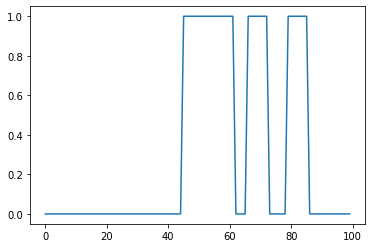

In [66]:
plt.plot(square_pulse)

In [67]:
def make_triangular_pulse():
    sample = np.zeros(100)
    for i in range(np.random.randint(1, 5)):  # making from 1 to 4 pulses
        start = np.random.randint(0, 80)
        width = np.random.randint(5, 20)
        if width % 2 == 1:
            width += 1  # if odd, make it even
        sample[start:start + width // 2] = np.linspace(0, 1, width // 2)
        sample[start + width // 2:start + width] = np.linspace(1, 0, width // 2)
    return sample

In [68]:
triangular_pulse = make_triangular_pulse()
triangular_pulse

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.16666667, 0.33333333, 0.5       , 0.66666667, 0.83333333,
       1.        , 1.        , 0.83333333, 0.66666667, 0.        ,
       0.125     , 0.25      , 0.375     , 0.5       , 0.625     ,
       0.75      , 0.875     , 1.        , 1.        , 0.875     ,
       0.75      , 0.625     , 0.5       , 0.375     , 0.25      ,
       0.125     , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.11111111, 0.22222222,
       0.33333333, 0.44444444, 0.55555556, 0.66666667, 0.77777778,
       0.        , 0.33333333, 0.66666667, 1.        , 1.        ,
       0.66666667, 0.33333333, 0.        , 0.33333333, 0.22222222,
       0.11111111, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

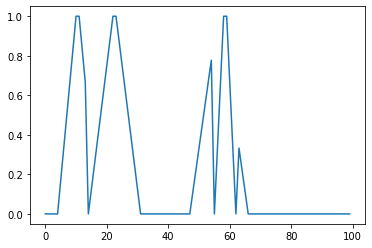

In [69]:
plt.plot(triangular_pulse)

In [70]:
n_each = 500
Xtrain = np.array([make_square_pulse() for i in range(n_each)] +
                   [make_triangular_pulse() for i in range(n_each)])
Ttrain = np.array(['square'] * n_each + ['triangular'] * n_each).reshape(-1, 1)
n_each = 500
Xtest = np.array([make_square_pulse() for i in range(n_each)] +
                   [make_triangular_pulse() for i in range(n_each)])
Ttest = np.array(['square'] * n_each + ['triangular'] * n_each).reshape(-1, 1)
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((1000, 100), (1000, 1), (1000, 100), (1000, 1))

In [71]:
np.newaxis == None

True

In [72]:
Xtrain = Xtrain[:, None, :]
Xtrain.shape

(1000, 1, 100)

In [73]:
Xtrain = Xtrain.reshape(Xtrain.shape[0], 1, -1)
Xtest = Xtest.reshape(Xtest.shape[0], 1, -1)
Xtrain.shape, Xtest.shape

((1000, 1, 100), (1000, 1, 100))

In [75]:
cnnet1 = CNN1D(100, [10, 5], [5, 5], 2, [10, 4], [1, 2], device=device)

n_epochs = 100
batch_size = 10
learning_rate = 0.001

cnnet1.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')


adam: Epoch 10 Loss 0.615
adam: Epoch 20 Loss 0.447
adam: Epoch 30 Loss 0.267
adam: Epoch 40 Loss 0.118
adam: Epoch 50 Loss 0.033
adam: Epoch 60 Loss 0.010
adam: Epoch 70 Loss 0.006
adam: Epoch 80 Loss 0.015
adam: Epoch 90 Loss 0.006
adam: Epoch 100 Loss 0.001


CNN1D(
  (conv_layers): ModuleList(
    (0): Conv1d(1, 10, kernel_size=(10,), stride=(1,))
    (1): Conv1d(10, 5, kernel_size=(4,), stride=(2,))
  )
  (fc_layers): ModuleList(
    (0): Linear(in_features=220, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=5, bias=True)
    (2): Linear(in_features=5, out_features=2, bias=True)
  )
)

In [76]:
Classes, _ = cnnet1.use(Xtest)
perc_correct = 100 * np.mean(Classes == Ttest)
print(f'Test accuracy in percent correct: {perc_correct:.2f}')
confusion_matrix(Classes, Ttest)

Test accuracy in percent correct: 99.10


,square,triangular
square,98.4,1.6
triangular,0.2,99.8


torch.Size([10, 10])

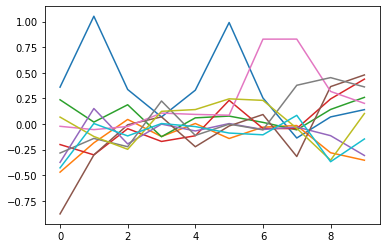

In [77]:
W = list(cnnet1.children())[0][0].weight.data.cpu()  # in case running on GPU
plt.plot(W[:, 0, :].T);
W[:, 0, :].T.shape

### Experiments on ECG Data

An [electrocardiogram](), or ECG, is a record in time of a voltage generated by the heart.  It can be used to diagnose abnormalities in the heart.

Public datasets containing ECG traces are available, such as the [Non-Invasive Fetal ECG Arrhythmia Database](https://physionet.org/content/nifeadb/1.0.0/) site. The data files there are in a standard waveform-database (WFDB) format.  As is often the case for most standard data formats you run in to, a python package exists for reading this data, called [wfdb](https://github.com/MIT-LCP/wfdb-python) that you can install using [conda](https://anaconda.org/conda-forge/wfdb).

This data set includes ECG from normal patients and from ones with arrythmias, with data file names like `ARR_01.dat` and `NR_01.dat`, respectively.  I have already downloaded these files, read them in using the `wfdb` package and collected them into segments of 2000 voltages.  The sample rate for this data is 1000 Hz, so 2000 voltages spans 2 seconds. To do this on your own, download this data set from [ecg.npy](https://www.cs.colostate.edu/~cs445/notebooks/ecg.npy) 

Now, the job for the `CNN1D` is to classify each 2000 sample segment into the classes `normal` or `arrythmia`.

After you have downloaded `ecg.npy`, you can load it and plot a few samples.

In [78]:
ecg = np.load('ecg.npy')
arr = ecg['arrythmia']
norm = ecg['normal']
arr.shape, norm.shape

((2429, 2000), (3634, 2000))

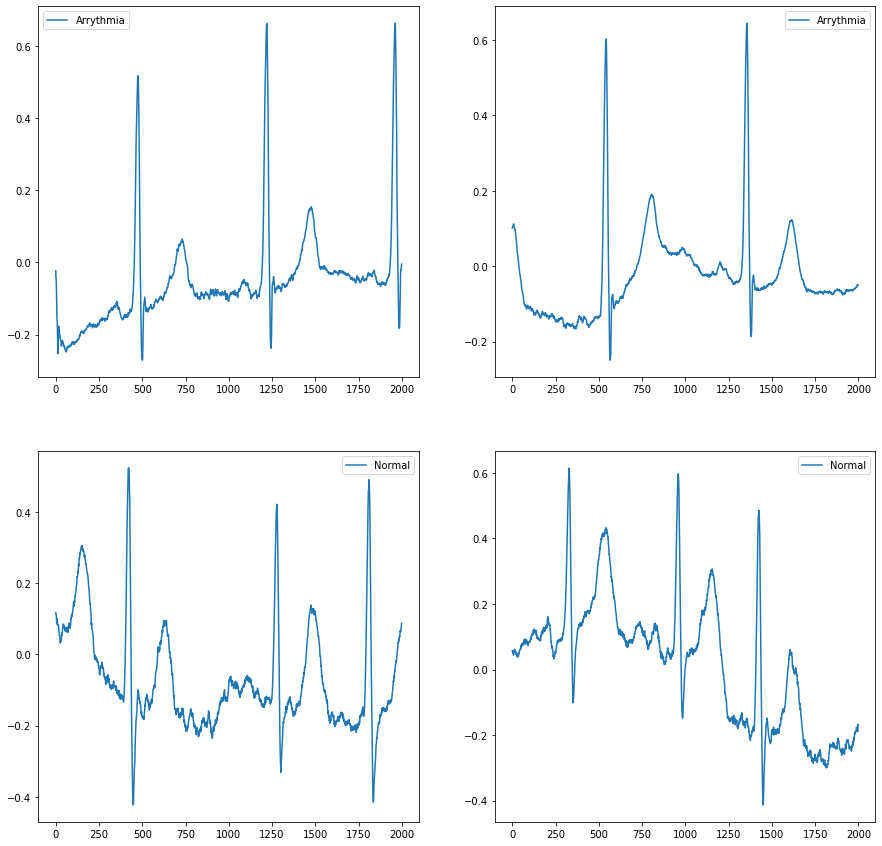

In [79]:
plt.figure(figsize=(15, 15))

plt.subplot(2, 2, 1)
plt.plot(arr[0])
plt.legend(('Arrythmia',))
plt.subplot(2, 2, 2)
plt.plot(arr[100])
plt.legend(('Arrythmia',))

plt.subplot(2, 2, 3)
plt.plot(norm[0])
plt.legend(('Normal',))
plt.subplot(2, 2, 4)
plt.plot(norm[100])
plt.legend(('Normal',));

Now, let's stack the `arr` and `norm` samples together, create class labels for each sample, randomly rearrange them, and divide into train and test sets.

In [80]:
X = np.vstack((arr, norm))
X = X.reshape(X.shape[0], 1, -1)
T = np.hstack((['arr'] * arr.shape[0], ['nr'] * norm.shape[0])).reshape(-1, 1)
n_samples = X.shape[0]
rows = np.arange(n_samples)
np.random.shuffle(rows)
n_train = int(n_samples * 0.8)
Xtrain = X[rows[:n_train], ...]
Ttrain = T[rows[:n_train], ...]
Xtest = X[rows[n_train:], ...]
Ttest = T[rows[n_train:], ...]

Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((4850, 1, 2000), (4850, 1), (1213, 1, 2000), (1213, 1))

In [81]:
Ttrain

array([['arr'],
       ['arr'],
       ['arr'],
       ...,
       ['nr'],
       ['arr'],
       ['nr']], dtype='<U3')

Okay, ready to train.  Create a `CNN1D` network with a statements like this.

In [34]:
cnn1d = CNN1D(Xtrain.shape[-1], [5, 10], [10, 10], 2, [100, 20], [20, 5], device=device)

Now, experiment we will run ten different network structures, patch sizes and strides and compare them with the percent accuracy on test data.  Combine the results of each of our runs and then we will display them in a `pandas.Dataframe` that includes the network structure and percent correct on train and test sets.

In [83]:
net_struct_results = []

In [84]:
def net_struct_experiment(n_hidden_conv, n_hidden_fc, patch_size_per_conv, stride_per_conv):
    n_epochs = 2000
    batch_size = 500
    learning_rate = 0.01
    
    my_CNN = CNN1D(Xtrain.shape[-1], n_hidden_conv, n_hidden_fc, 2, patch_size_per_conv, stride_per_conv, device = device)
    
    my_CNN.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')
    
    class_train, _ = my_CNN.use(Xtrain)
    percentage_correct_train = 100 * np.mean(class_train == Ttrain)
    
    class_test, _ = my_CNN.use(Xtest)
    percentage_correct_test = 100 * np.mean(class_test == Ttest)
    
    net_struct_results.append([n_hidden_conv, n_hidden_fc, patch_size_per_conv, stride_per_conv, percentage_correct_train, percentage_correct_test])
    

In [86]:
net_struct_experiment([], [], [], [])

adam: Epoch 200 Loss 0.698
adam: Epoch 400 Loss 0.680
adam: Epoch 600 Loss 0.669
adam: Epoch 800 Loss 0.652
adam: Epoch 1000 Loss 0.646
adam: Epoch 1200 Loss 0.648
adam: Epoch 1400 Loss 0.627
adam: Epoch 1600 Loss 0.614
adam: Epoch 1800 Loss 0.635
adam: Epoch 2000 Loss 0.613


In [90]:
net_struct_experiment([10], [1], [1], [1])

adam: Epoch 200 Loss nan
adam: Epoch 400 Loss nan
adam: Epoch 600 Loss nan
adam: Epoch 800 Loss nan
adam: Epoch 1000 Loss nan
adam: Epoch 1200 Loss nan
adam: Epoch 1400 Loss nan
adam: Epoch 1600 Loss nan
adam: Epoch 1800 Loss nan
adam: Epoch 2000 Loss nan


In [91]:
net_struct_experiment([1], [10], [1], [1])

adam: Epoch 200 Loss 0.674
adam: Epoch 400 Loss 0.674
adam: Epoch 600 Loss 0.674
adam: Epoch 800 Loss 0.674
adam: Epoch 1000 Loss 0.674
adam: Epoch 1200 Loss 0.674
adam: Epoch 1400 Loss 0.674
adam: Epoch 1600 Loss 0.674
adam: Epoch 1800 Loss 0.674
adam: Epoch 2000 Loss 0.674


In [92]:
net_struct_experiment([1], [1], [10], [1])

adam: Epoch 200 Loss 0.673
adam: Epoch 400 Loss 0.673
adam: Epoch 600 Loss 0.673
adam: Epoch 800 Loss 0.673
adam: Epoch 1000 Loss 0.673
adam: Epoch 1200 Loss 0.673
adam: Epoch 1400 Loss 0.673
adam: Epoch 1600 Loss 0.673
adam: Epoch 1800 Loss 0.673
adam: Epoch 2000 Loss 0.673


In [93]:
net_struct_experiment([1], [1], [1], [10])

adam: Epoch 200 Loss 0.633
adam: Epoch 400 Loss 0.629
adam: Epoch 600 Loss 0.627
adam: Epoch 800 Loss 0.626
adam: Epoch 1000 Loss 0.625
adam: Epoch 1200 Loss 0.624
adam: Epoch 1400 Loss 0.623
adam: Epoch 1600 Loss 0.623
adam: Epoch 1800 Loss 0.622
adam: Epoch 2000 Loss 0.622


In [94]:
net_struct_experiment([10], [10], [1], [1])

adam: Epoch 200 Loss 0.674
adam: Epoch 400 Loss 0.674
adam: Epoch 600 Loss 0.674
adam: Epoch 800 Loss 0.674
adam: Epoch 1000 Loss 0.674
adam: Epoch 1200 Loss 0.674
adam: Epoch 1400 Loss 0.674
adam: Epoch 1600 Loss 0.674
adam: Epoch 1800 Loss 0.674
adam: Epoch 2000 Loss 0.674


In [95]:
net_struct_experiment([10], [10], [1], [10])

adam: Epoch 200 Loss 0.674
adam: Epoch 400 Loss 0.674
adam: Epoch 600 Loss 0.674
adam: Epoch 800 Loss 0.674
adam: Epoch 1000 Loss 0.674
adam: Epoch 1200 Loss 0.674
adam: Epoch 1400 Loss 0.674
adam: Epoch 1600 Loss 0.674
adam: Epoch 1800 Loss 0.674
adam: Epoch 2000 Loss 0.674


In [96]:
net_struct_experiment([10], [10], [10], [1])

adam: Epoch 200 Loss 0.636
adam: Epoch 400 Loss 0.612
adam: Epoch 600 Loss 0.611
adam: Epoch 800 Loss 0.629
adam: Epoch 1000 Loss 0.593
adam: Epoch 1200 Loss 0.567
adam: Epoch 1400 Loss 0.582
adam: Epoch 1600 Loss 0.555
adam: Epoch 1800 Loss 0.552
adam: Epoch 2000 Loss 0.555


In [97]:
net_struct_experiment([10], [10], [10], [10])

adam: Epoch 200 Loss 0.213
adam: Epoch 400 Loss 0.219
adam: Epoch 600 Loss 0.207
adam: Epoch 800 Loss 0.119
adam: Epoch 1000 Loss 0.113
adam: Epoch 1200 Loss 0.104
adam: Epoch 1400 Loss 0.102
adam: Epoch 1600 Loss 0.112
adam: Epoch 1800 Loss 0.103
adam: Epoch 2000 Loss 0.100


In [100]:
net_struct_experiment([1], [10, 10, 10, 10], [1], [1])

adam: Epoch 200 Loss 0.674
adam: Epoch 400 Loss 0.674
adam: Epoch 600 Loss 0.674
adam: Epoch 800 Loss 0.674
adam: Epoch 1000 Loss 0.674
adam: Epoch 1200 Loss 0.674
adam: Epoch 1400 Loss 0.674
adam: Epoch 1600 Loss 0.611
adam: Epoch 1800 Loss 0.517
adam: Epoch 2000 Loss 0.519


In [105]:
net_struct_experiment([10, 10], [10, 10, 100, 100], [20, 5], [20, 5])

adam: Epoch 200 Loss 0.065
adam: Epoch 400 Loss 0.046
adam: Epoch 600 Loss 0.079
adam: Epoch 800 Loss 0.009
adam: Epoch 1000 Loss 0.073
adam: Epoch 1200 Loss 0.015
adam: Epoch 1400 Loss 0.079
adam: Epoch 1600 Loss 0.100
adam: Epoch 1800 Loss 0.047
adam: Epoch 2000 Loss 0.026


In [106]:
net_struct_experiment([10, 100, 1000], [5, 10, 100, 100], [20, 10, 5], [20, 5, 15])

adam: Epoch 200 Loss 0.379
adam: Epoch 400 Loss 0.190
adam: Epoch 600 Loss 0.196
adam: Epoch 800 Loss 0.138
adam: Epoch 1000 Loss 0.180
adam: Epoch 1200 Loss 0.142
adam: Epoch 1400 Loss 0.097
adam: Epoch 1600 Loss 0.128
adam: Epoch 1800 Loss 0.290
adam: Epoch 2000 Loss 0.246


In [112]:
net_struct_experiment([10, 100, 100, 1000], [25, 10, 100, 1000], [20, 10, 1, 1], [20, 5, 5, 10])

adam: Epoch 200 Loss 0.661
adam: Epoch 400 Loss 0.653
adam: Epoch 600 Loss 0.701
adam: Epoch 800 Loss 0.700
adam: Epoch 1000 Loss 0.852
adam: Epoch 1200 Loss 0.843
adam: Epoch 1400 Loss 0.684
adam: Epoch 1600 Loss 0.682
adam: Epoch 1800 Loss 0.694
adam: Epoch 2000 Loss 0.706


In [113]:
pandas.DataFrame(net_struct_results, columns=("Hidden Units/Convs", "Hidden Units/FC", "Patch Size/Conv", "Stride/Conv", "Train Accuracy", "Test Accuracy"))

,Hidden Units/Convs,Hidden Units/FC,Patch Size/Conv,Stride/Conv,Train Accuracy,Test Accuracy
0,[],[],[],[],65.319588,50.948063
1,[10],[1],[1],[1],40.123711,39.818631
2,[10],[1],[1],[1],40.123711,39.818631
3,[1],[10],[1],[1],59.876289,60.181369
4,[1],[1],[10],[1],59.876289,60.181369
5,[1],[1],[1],[10],59.876289,60.181369
6,[10],[10],[1],[1],59.876289,60.181369
7,[10],[10],[1],[10],59.876289,60.181369
8,[10],[10],[10],[1],69.525773,65.210223
9,[10],[10],[10],[10],94.556701,64.056059


In an effort to understand the impact of variables on the neural network, I conducted a total of 16 experiments on the ECG data. Out of these 16 experiments, 13 did not perform well, with both test and train accuracy below 90%. The remaining 3 experiments, which had a higher level of complexity, performed above 90% only on the training data. I attribute this poor performance to the complexity of the data, which requires network parameters that can capture a large number of patterns. I attempted to address this issue by using more complex network architectures, but they did not perform well either, likely due to significant overfitting.

There were significant improvements in the accuracy of the architectures when additional hidden units/FC, patch size, or stride were added. For instance, architecture (2) had a train accuracy of 40%, which increased by 20% to 60% when 1 layer of 10 hidden units/FC was added (architecture (3)). Similarly, adding a single layer of 10 patch size/conv or stride/conv units also resulted in a significant improvement in train accuracy. The combination of all three factors in architecture (9) led to a 30% increase in train accuracy to 94%. Although architecture (9) only had one layer of 10 units for each factor, it performed exceptionally well, making the gains in (12) and (13), which had an accuracy of around 96% after additional training, seem modest in comparison.

In conclusion, the patch size plays a critical role in the performance of the neural network. By providing the network with greater awareness of the surrounding data, the patch size can lead to improved accuracy. This was evident in architecture (4), where adding 1 layer of 10 patch size units resulted in a 20% increase in accuracy. Due to the size of this dataset, the ability to take surrounding data into account can lead to phenomenal performance improvements.